In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import qldpc
from qldpc import abstract, codes
import cirq
import stimcirq
import stim
import numpy as np

import sinter
import pymatching

import matplotlib.pyplot as plt

In [3]:
#noise model 
class MyNoiseModel(cirq.NoiseModel):
    def __init__(self, single_qubit_error = None, two_qubit_error = None) -> None:
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        
    def noisy_operation(self, op: cirq.Operation) -> cirq.OP_TREE:
        if isinstance(op.gate, cirq.PauliMeasurementGate):
            return op
        if len(op.qubits) == 1:
            return [op, cirq.depolarize(self.single_qubit_error, cirq.num_qubits(op)).on(*op.qubits)]
        elif len(op.qubits) == 2:
            return [op, cirq.depolarize(self.two_qubit_error, cirq.num_qubits(op)).on(*op.qubits)]
        else: 
            raise ValueError("This circuit should be decomposed before implementing a Noise Model")

In [4]:
def get_toric_code(distance) -> codes.CSSCode:
    """Rotated toric code as a quantum Tanner code."""
    group = abstract.Group.product(abstract.CyclicGroup(distance), repeat=2)
    shift_x, shift_y = group.generators
    subset_a = [shift_x, ~shift_x]
    subset_b = [shift_y, ~shift_y]
    subcode = codes.BitCode.repetition(2)
    return codes.QTCode(subset_a, subset_b, subcode)

In [5]:
class SurfaceCode(codes.CSSCode): 
    def __init__(self, distance):
        assert distance == 3
        self.distance = distance
        code_x = np.zeros((4,9), dtype=int)
        code_z = np.zeros((4,9), dtype=int)
        
        code_x = np.zeros((4, 9), dtype=int)
        code_x[0, 0] = 1
        code_x[0, 3] = 1
        code_x[1, 1] = 1
        code_x[1, 2] = 1
        code_x[1, 4] = 1
        code_x[1, 5] = 1
        code_x[2, 3] = 1
        code_x[2, 4] = 1
        code_x[2, 6] = 1
        code_x[2, 7] = 1
        code_x[3, 5] = 1
        code_x[3, 8] = 1

        code_z = np.zeros((4, 9), dtype=int)
        code_z[0, 1] = 1
        code_z[0, 2] = 1
        code_z[1, 0] = 1
        code_z[1, 1] = 1
        code_z[1, 3] = 1
        code_z[1, 4] = 1
        code_z[2, 4] = 1
        code_z[2, 5] = 1
        code_z[2, 7] = 1
        code_z[2, 8] = 1
        code_z[3, 6] = 1
        code_z[3, 7] = 1
 
        codes.CSSCode.__init__(self, code_x, code_z)

In [6]:
distance = 3
code = SurfaceCode(distance)

In [13]:
class SyndromeExtractionCircuit:
    def __init__(self, qldpc_code, error_type, single_qubit_error = 0.01, two_qubit_error = 0.01, rounds = 3) -> None:
        self.code = qldpc_code
        self.rounds = rounds
        self.error_type = error_type
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        self.ancillas= self.get_ancillas()
        self.data_qubits = self.get_data_qubits()
        self.qubit_index = self.get_stim_qubit_index()
        self.logical_x, self.logical_z = self.get_logical_operators()
        self.cirq_circuit = self.code_to_cirq_circuit()
        self.decomposed_cirq_circuit = self.cirq_circuit.map_operations(self.decompose_extraction_gates)
        self.noisy_circuit = self.circuit_with_noise()
        self.stim_circuit = self.code_to_stim_circuit()
        

    def insert_measurements(self, circuit):
        for qubit, pauli in self.ancillas.items():
            if pauli == self.error_type:
                circuit += [cirq.measure(cirq.NamedQubit(str(qubit))), cirq.reset(cirq.NamedQubit(str(qubit)))]
        return circuit

    
    def get_stim_qubit_index(self): #see if you can factor out total_qubits to use the specific ancillas 
        qubit_index_dict = {}
        total_qubits = [ancilla for ancilla, pauli in self.ancillas.items() if pauli == self.error_type] + self.data_qubits
        for index, qubit in enumerate(total_qubits):
            qubit_index_dict[qubit] = index
            
        return qubit_index_dict
        
    
    def get_ancillas(self): #include option to factor out whether or not you want specific ancillas
        ancillas = {}
        if self.error_type:
            for ancilla in [qubit for qubit in sorted(self.code.graph.nodes) if not qubit.is_data]:
                for neighbor in self.code.graph.successors(ancilla):
                    ancillas[ancilla] = str(self.code.graph[ancilla][neighbor][qldpc.objects.Pauli]) # a bit ugly, try to clean. only works for CSS
            
        return ancillas
    
    
    def get_data_qubits(self):
        data_qubits = []
        for data_qubit in [qubit for qubit in sorted(self.code.graph.nodes) if qubit.is_data]:
            data_qubits.append(cirq.NamedQubit(str(data_qubit)))
        return data_qubits
    

    #use the nodes of the graph rather than the code

    def code_to_cirq_circuit(self):
        circuit = cirq.Circuit()
        for ancilla, pauli in self.ancillas.items():
            if pauli == self.error_type: ## If error type is factored out, don't need this
                string = {
                    cirq.NamedQubit(str(ancilla)): pauli
                        } 
#                 circuit += cirq.reset(cirq.NamedQubit(str(ancilla)))
                circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
                for neighbor in self.code.graph.successors(ancilla):
                    circuit += cirq.PauliString(string).controlled_by(cirq.NamedQubit(str(neighbor)))
                circuit += cirq.H(cirq.NamedQubit(str(ancilla)))

        return circuit
    
    def get_logical_operators(self):
        logical_x = self.code.get_random_logical_op(qldpc.objects.Pauli.X, ensure_nontrivial=True)
        logical_z = self.code.get_random_logical_op(qldpc.objects.Pauli.Z, ensure_nontrivial=True)
        return logical_x, logical_z 
        

    def decompose_extraction_gates(self, op): 
        if isinstance(op, cirq.ControlledOperation) and isinstance(op.sub_operation, cirq.PauliString) and len(op.controls) == 1:
            return [pauli.on(qubit).controlled_by(*op.controls, control_values = op.control_values) for qubit , pauli in op.sub_operation.items()]
        return op 
    
    def circuit_with_noise(self):
        return self.decomposed_cirq_circuit.with_noise(MyNoiseModel(self.single_qubit_error, self.two_qubit_error))
    
    def code_to_stim_circuit(self): 
        ancillas = [ancilla for ancilla, pauli in self.ancillas.items() if pauli == self.error_type] ## IF error type is factored out, don't need this
        stim_circuit = stim.Circuit()
        stim_circuit.append("R", [self.qubit_index[ancilla] for ancilla in ancillas])
        stim_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
        stim_circuit += stimcirq.cirq_circuit_to_stim_circuit(self.noisy_circuit) 
        stim_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
        stim_circuit.append("MR", [self.qubit_index[ancilla] for ancilla in ancillas])
        stim_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
        rounds_circuit = stim_circuit[1:]
        rounds_circuit.append("SHIFT_COORDS", [], [0,0,1])
        for i in range(1, len(ancillas) + 1 , 1):
            stim_circuit.append("DETECTOR", stim.target_rec(-i))
            rounds_circuit.append("DETECTOR", (stim.target_rec(-i), stim.target_rec(-i - len(ancillas))))

            
        #choosing the logical operator
        if self.error_type == "Z":
            logical_operator = self.logical_z
            measurement = "M"
        elif self.error_type == "X":
            logical_operator = self.logical_x  
            measurement = "MX" #try MX for the X type
        observable_circuit = stim.Circuit()
        observable_dictionary = {}
        counter = -len(self.data_qubits)
        
        observable_circuit.append("X_ERROR", [self.qubit_index[data_qubit] for data_qubit in self.data_qubits], self.single_qubit_error)        
        for data_qubit in self.data_qubits:
            observable_dictionary[self.qubit_index[data_qubit]] = counter
            counter = counter + 1
            observable_circuit.append(measurement, [self.qubit_index[data_qubit]])
        
        for ancilla in ancillas:
            ancilla_index = [-len(self.data_qubits) - ancillas[::-1].index(ancilla) - 1]
            neighbor_indices = [-self.data_qubits[::-1].index(cirq.NamedQubit(str(data_qubit)))-1 
                                for data_qubit in self.code.graph.successors(ancilla)]
            total_detection = ancilla_index + neighbor_indices
            observable_circuit.append("DETECTOR", [stim.target_rec(i) for i in total_detection])
            
        observable_include = [stim.target_rec(observable_dictionary[self.qubit_index[qubit]]) 
                              for observable, qubit in zip(logical_operator, self.data_qubits) if observable == 1]
        
        observable_circuit.append("OBSERVABLE_INCLUDE", observable_include, 0)
        return stim_circuit + (rounds_circuit * (self.rounds-1)) + observable_circuit 

        
distance = 3
code = SurfaceCode(distance)

In [14]:
circuit =  SyndromeExtractionCircuit(code, "X", rounds = 3).stim_circuit

print(circuit)

R 0 1 2 3
X_ERROR(0.01) 0 1 2 3
H 0 1 2 3
TICK
DEPOLARIZE1(0.01) 0 1 2 3
TICK
CX 4 0 5 1
TICK
DEPOLARIZE2(0.01) 4 0 5 1
TICK
CX 7 0 6 1
TICK
DEPOLARIZE2(0.01) 7 0 6 1
TICK
H 0
CX 8 1 7 2
TICK
DEPOLARIZE1(0.01) 0
DEPOLARIZE2(0.01) 8 1 7 2
TICK
CX 9 1 8 2
TICK
DEPOLARIZE2(0.01) 9 1 8 2
TICK
H 1
CX 10 2 9 3
TICK
DEPOLARIZE1(0.01) 1
DEPOLARIZE2(0.01) 10 2 9 3
TICK
CX 11 2 12 3
TICK
DEPOLARIZE2(0.01) 11 2 12 3
TICK
H 2 3
TICK
DEPOLARIZE1(0.01) 2 3
TICK
X_ERROR(0.01) 0 1 2 3
MR 0 1 2 3
X_ERROR(0.01) 0 1 2 3
DETECTOR rec[-1]
DETECTOR rec[-2]
DETECTOR rec[-3]
DETECTOR rec[-4]
REPEAT 2 {
    X_ERROR(0.01) 0 1 2 3
    H 0 1 2 3
    TICK
    DEPOLARIZE1(0.01) 0 1 2 3
    TICK
    CX 4 0 5 1
    TICK
    DEPOLARIZE2(0.01) 4 0 5 1
    TICK
    CX 7 0 6 1
    TICK
    DEPOLARIZE2(0.01) 7 0 6 1
    TICK
    H 0
    CX 8 1 7 2
    TICK
    DEPOLARIZE1(0.01) 0
    DEPOLARIZE2(0.01) 8 1 7 2
    TICK
    CX 9 1 8 2
    TICK
    DEPOLARIZE2(0.01) 9 1 8 2
    TICK
    H 1
    CX 10 2 9 3
    TICK
    DEPOL

In [15]:
import stimcirq
stimcirq.stim_circuit_to_cirq_circuit(circuit)

┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐
                                                                                                                                                                                                                                                          [                                     ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐                                                                      ]
                                                                                                                                                                                                                                                          [ 0: ────X[prob=0.01]───H───D(0.01)────X──────#2─────────────────X──────#2─────────────────H──────D(0.01)───────────────────────────────────────────────────────────────────────────────────────────────────────X[prob=0.01]───MR('4')───X[prob=0.01]─────────────── ]
                                                                                                                                                                                                                                                          [                                      │      │                  │      │                                                                                                                                                                                            ]
                                                                                                                                                                                                                                                          [ 1: ────X[prob=0.01]───H───D(0.01)────┼X─────┼──────#2──────────┼X─────┼──────#2──────────X──────#2─────────────────X──────#2─────────────────H──────D(0.01)───────────────────────────────────────────────────X[prob=0.01]───MR('5')───X[prob=0.01]─────────────── ]
                                                                                                                                                                                                                                                          [                                      ││     │      │           ││     │      │           │      │                  │      │                                                                                                                                        ]
                                                                                                                                                                                                                                                          [ 2: ────X[prob=0.01]───H───D(0.01)────┼┼─────┼──────┼───────────┼┼─────┼──────┼───────────┼X─────┼──────#2──────────┼X─────┼──────#2──────────X──────#2─────────────────X──────#2────────────────H───D(0.01)───X[prob=0.01]───MR('6')───X[prob=0.01]─────────────── ]
                                                                                                                                                                                                                                                          [                                      ││     │      │           ││     │      │           ││     │      │           ││     │      │           │      │                  │      │                                                                                    ]
                                                                                                                                                                                                                                                          [ 3: 

In [20]:
circuit =  SyndromeExtractionCircuit(code, "Z", rounds = 3).stim_circuit

print(circuit)

R 0 1 2 3
X_ERROR(0.01) 0 1 2 3
H 0 1 2 3
TICK
DEPOLARIZE1(0.01) 0 1 2 3
TICK
CZ 5 0 4 1 10 3
TICK
DEPOLARIZE2(0.01) 5 0 4 1 10 3
TICK
CZ 6 0 5 1
TICK
DEPOLARIZE2(0.01) 6 0 5 1
TICK
H 0
CZ 7 1
TICK
DEPOLARIZE1(0.01) 0
DEPOLARIZE2(0.01) 7 1
TICK
CZ 8 1
TICK
DEPOLARIZE2(0.01) 8 1
TICK
H 1
CZ 8 2
TICK
DEPOLARIZE1(0.01) 1
DEPOLARIZE2(0.01) 8 2
TICK
CZ 9 2
TICK
DEPOLARIZE2(0.01) 9 2
TICK
CZ 11 2
TICK
DEPOLARIZE2(0.01) 11 2
TICK
CZ 12 2 11 3
TICK
DEPOLARIZE2(0.01) 12 2 11 3
TICK
H 2 3
TICK
DEPOLARIZE1(0.01) 2 3
TICK
X_ERROR(0.01) 0 1 2 3
MR 0 1 2 3
X_ERROR(0.01) 0 1 2 3
DETECTOR rec[-1]
DETECTOR rec[-2]
DETECTOR rec[-3]
DETECTOR rec[-4]
REPEAT 2 {
    X_ERROR(0.01) 0 1 2 3
    H 0 1 2 3
    TICK
    DEPOLARIZE1(0.01) 0 1 2 3
    TICK
    CZ 5 0 4 1 10 3
    TICK
    DEPOLARIZE2(0.01) 5 0 4 1 10 3
    TICK
    CZ 6 0 5 1
    TICK
    DEPOLARIZE2(0.01) 6 0 5 1
    TICK
    H 0
    CZ 7 1
    TICK
    DEPOLARIZE1(0.01) 0
    DEPOLARIZE2(0.01) 7 1
    TICK
    CZ 8 1
    TICK
    DEPOLARIZE2(0.0

In [21]:
stimcirq.stim_circuit_to_cirq_circuit(circuit)

┌───┐   ┌─────────────────────┐   ┌──┐   ┌──────────────┐                                                                         ┌──┐   ┌──────────────┐
                                                                                                                                                                                                                                                          [                                     ┌───┐   ┌─────────────────────┐   ┌──┐   ┌──────────────┐                                                                         ┌──┐   ┌──────────────┐                                                                      ]
                                                                                                                                                                                                                                                          [ 0: ────X[prob=0.01]───H───D(0.01)────@───────#2────────────────────────@──────#2────────────────H───D(0.01)───────────────────────────────────────────────────────────────────────────────────────────────────X[prob=0.01]───MR('4')───X[prob=0.01]─────────────── ]
                                                                                                                                                                                                                                                          [                                      │       │                         │      │                                                                                                                                                                                    ]
                                                                                                                                                                                                                                                          [ 1: ────X[prob=0.01]───H───D(0.01)────┼@──────┼──────#2─────────────────┼@─────┼──────#2─────────@───#2────────@───#2────────H───D(0.01)───────────────────────────────────────────────────────────────────────X[prob=0.01]───MR('5')───X[prob=0.01]─────────────── ]
                                                                                                                                                                                                                                                          [                                      ││      │      │                  ││     │      │          │   │         │   │                                                                                                                                                ]
                                                                                                                                                                                                                                                          [ 2: ────X[prob=0.01]───H───D(0.01)────┼┼──────┼──────┼──────────────────┼┼─────┼──────┼──────────┼───┼─────────┼───┼─────────@───#2────────@───#2────────@───#2─────────@──────#2────────────────H───D(0.01)───X[prob=0.01]───MR('6')───X[prob=0.01]─────────────── ]
                                                                                                                                                                                                                                                          [                                      ││      │      │                  ││     │      │          │   │         │   │         │   │         │   │         │   │          │      │                                                                                    ]
                                                                                                                                                                                                                                                          [ 3: 

In [19]:
p_min = -5
p_max = -1
num_points = 10
rounds = 3

code_tasks = [
    sinter.Task(
        circuit = SyndromeExtractionCircuit(code, "Z", noise, noise, rounds=rounds).stim_circuit,
        json_metadata={'d': 3, 'r': rounds, 'p': noise},
    )
    for noise in np.logspace(p_min,p_max, num_points)
]

collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
    print_progress=True,
)
collected_surface_code_stats
###############################################################################

Starting 4 workers...
10 cases left:
    pymatching processes=4  ~core_mins_left=1       shots_left=808000   errors_left=5000    {d=3,p=1e-05,r=3}
    pymatching processes=0  ~core_mins_left=21      shots_left=999500   errors_left=5000    {d=3,p=2.782559402207126e-05,r=3}
    pymatching processes=0  ~core_mins_left=35      shots_left=999700   errors_left=5000    {d=3,p=7.742636826811278e-05,r=3}
    pymatching processes=0  ~core_mins_left=104     shots_left=999900   errors_left=5000    {d=3,p=0.00021544346900318823,r=3}
Done collecting


[sinter.TaskStats(strong_id='a3bf0a1c26cc0e20bf5862b253ff464897e142997d4d6796664f4f54cf2d0098', decoder='pymatching', json_metadata={'d': 3, 'r': 3, 'p': 7.742636826811278e-05}, shots=1000000, errors=2, seconds=0.9159650150068046),
 sinter.TaskStats(strong_id='89b2d2ab9c826255b6497d2f976549871df9bc0aed3237a7e29a0e1ed8a63f25', decoder='pymatching', json_metadata={'d': 3, 'r': 3, 'p': 2.782559402207126e-05}, shots=1000000, seconds=0.9282452750048833),
 sinter.TaskStats(strong_id='d21fd7fbb11d0cf38172e2900bc6c934710f81dee6a13b5575f8bd072249b1ab', decoder='pymatching', json_metadata={'d': 3, 'r': 3, 'p': 0.00021544346900318823}, shots=1000000, errors=5, seconds=0.9229506629999378),
 sinter.TaskStats(strong_id='4f891b41e61ea1e883d022e12a5f91c41df1a0149233a1d0b17697a93bb15188', decoder='pymatching', json_metadata={'d': 3, 'r': 3, 'p': 1e-05}, shots=1000000, seconds=0.9775476359900495),
 sinter.TaskStats(strong_id='ec5b418ecd86d228fd2df8ff7c26973e2fd0450ec69fbbf9df80b73f159fa66e', decoder='py

0 1000000
physical error rate: 7.742636826811278e-05 logical error rate: 0.0 distance: 3
0 1000000
physical error rate: 2.782559402207126e-05 logical error rate: 0.0 distance: 3
0 1000000
physical error rate: 1e-05 logical error rate: 0.0 distance: 3
7 1000000
physical error rate: 0.00021544346900318823 logical error rate: 7e-06 distance: 3
45 1000000
physical error rate: 0.0005994842503189409 logical error rate: 4.5e-05 distance: 3
363 1000000
physical error rate: 0.0016681005372000592 logical error rate: 0.000363 distance: 3
2912 1000000
physical error rate: 0.004641588833612777 logical error rate: 0.002912 distance: 3
5110 246601
physical error rate: 0.012915496650148827 logical error rate: 0.02072173267748306 distance: 3
5003 40216
physical error rate: 0.03593813663804626 logical error rate: 0.12440322259797096 distance: 3
5003 13064
physical error rate: 0.1 logical error rate: 0.38296080832823026 distance: 3


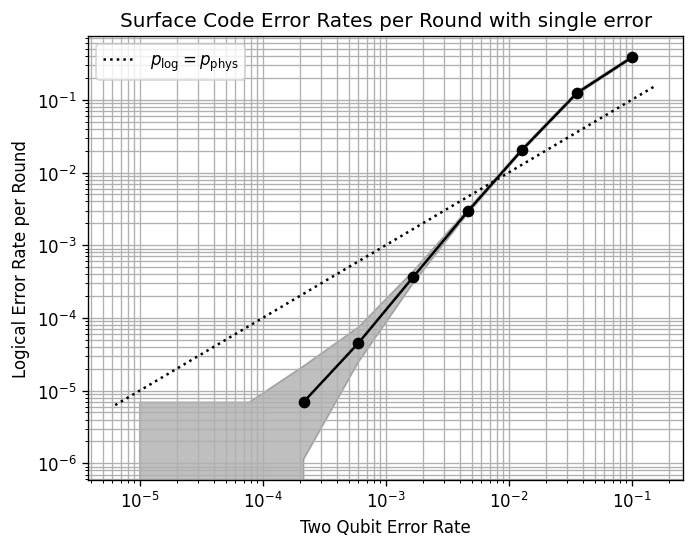

In [18]:
fig,ax = plt.subplots(1,1)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stats: stats.json_metadata['p'],
#     group_func = lambda stats: stats.json_metadata['d'],
#     failure_units_per_shot_func = lambda stats: stats.json_metadata['r'],

)

prob_vals = np.logspace(p_min,p_max, num_points)
error_vals = np.zeros((num_points, num_points))
shot_vals = np.empty_like(error_vals)


for stat in collected_surface_code_stats:
    error = stat.json_metadata["p"]
    distance = stat.json_metadata["d"]
    stat_index = (list(prob_vals).index(error))
    error_vals[stat_index] = stat.errors
    shot_vals[stat_index] = stat.shots
    print(stat.errors, stat.shots)
    print("physical error rate:", error, "logical error rate:" ,stat.errors/stat.shots, "distance:", distance)



ax.loglog()
ref_min = max(ax.get_xlim()[0], ax.get_ylim()[0])
ref_max = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([ref_min, ref_max], [ref_min, ref_max], "k:", label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$")
ax.set_title(f"Surface Code Error Rates per Round with single error")
ax.set_xlabel("Two Qubit Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

In [478]:
### using the stim package to graph
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=3,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)

# cirq_circuit = stimcirq.stim_circuit_to_cirq_circuit(surface_code_circuit)
# print(cirq_circuit)


In [497]:
p_min = -5
p_max = -1
num_points = 10
rounds = 3

surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d, 'p': noise},
    )
    for d in [3]
    for noise in np.logspace(p_min,p_max, num_points)
]

collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
    print_progress=True,
)

Starting 4 workers...
Done collecting


0 1000000
physical error rate: 1e-05 logical error rate: 0.0 distance: 3
1 1000000
physical error rate: 2.782559402207126e-05 logical error rate: 1e-06 distance: 3
9 1000000
physical error rate: 7.742636826811278e-05 logical error rate: 9e-06 distance: 3
41 1000000
physical error rate: 0.00021544346900318823 logical error rate: 4.1e-05 distance: 3
280 1000000
physical error rate: 0.0005994842503189409 logical error rate: 0.00028 distance: 3
2149 1000000
physical error rate: 0.0016681005372000592 logical error rate: 0.002149 distance: 3
5172 342120
physical error rate: 0.004641588833612777 logical error rate: 0.01511750263065591 distance: 3
5000 56763
physical error rate: 0.012915496650148827 logical error rate: 0.08808554868488276 distance: 3
5036 14728
physical error rate: 0.03593813663804626 logical error rate: 0.34193373166757196 distance: 3
5076 10240
physical error rate: 0.1 logical error rate: 0.495703125 distance: 3


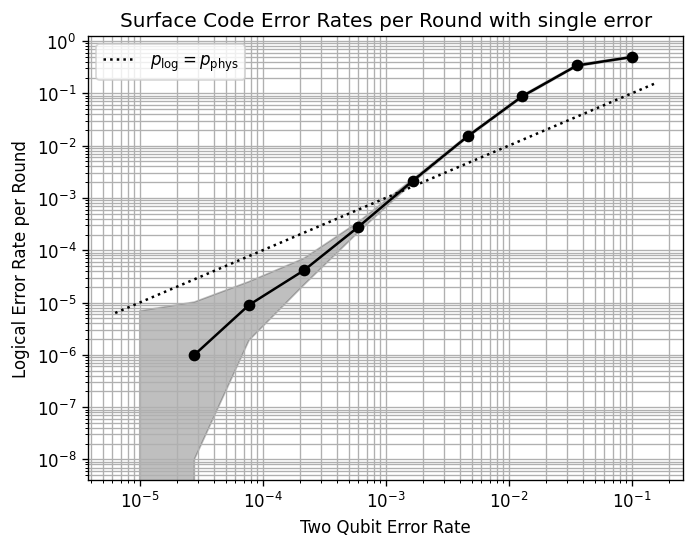

In [498]:
fig,ax = plt.subplots(1,1)

x_func = np.logspace(p_min, p_max, num_points)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stats: stats.json_metadata['p'],
#     group_func = lambda stats: stats.json_metadata['d'],
#     failure_units_per_shot_func = lambda stats: stats.json_metadata['r'],

)

prob_vals = np.logspace(p_min,p_max, num_points)
error_vals = np.zeros((num_points, num_points))
shot_vals = np.empty_like(error_vals)


for stat in collected_surface_code_stats:
    error = stat.json_metadata["p"]
    distance = stat.json_metadata["d"]
    stat_index = (list(prob_vals).index(error))
    error_vals[stat_index] = stat.errors
    shot_vals[stat_index] = stat.shots
    print(stat.errors, stat.shots)
    print("physical error rate:", error, "logical error rate:" ,stat.errors/stat.shots, "distance:", distance)



ax.loglog()
ref_min = max(ax.get_xlim()[0], ax.get_ylim()[0])
ref_max = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([ref_min, ref_max], [ref_min, ref_max], "k:", label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$")
ax.set_title(f"Surface Code Error Rates per Round with single error")
ax.set_xlabel("Two Qubit Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

In [508]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)


print(surface_code_circuit)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
X_ERROR(0.

In [510]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_x",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)


print(surface_code_circuit)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
RX 1 3 5 8 10 12 15 17 19
Z_ERROR(0.01) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
X_ERROR(0